# Taming text
In these notebooks, we analyse the content of Hillary Clinton's emails that went out during the email controversy of 2016. We will: 
* generate a word cloud based on the raw corpus
* perform a standard text preprocessing consisting in tokenization, stemming and/or lemmatization and stopwords removal
* perform a sentiment analysis to know what H.Clinton thinks of each country, using the library pycountry
* run topic modelling over the whole corpus, tuning the parameters

This present notebook performs the third steps.

# Question 2

### Sentiment analysis
We first perform a sentiment analysis on every email message. On the dataframe characterizing each email, we add a field "Sentiment" that corresponds to the sentiment that emanates from the message. We have chosen to use the `SentimentIntensityAnalyzser` method of `nltk.sentiment.vader` module.
For this step of the analysis, we do not need any specific preprocessing of the data since any word can be important for the meaning and the sentiment of the sentence.

In [1]:
import pandas as pd
import numpy as np
import pycountry
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from nltk import wordpunct_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict

/home/ondine/anaconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# Read the cleaned dataframe and drop nan entries
bodyDF = pd.read_csv('hillary-clinton-emails/BodyEmails.csv')
emails = bodyDF.dropna()
emails = emails.reset_index(drop=True)

# Initializations
sid = SentimentIntensityAnalyzer()
sentiment = []

# Loop over the emails, and scores the sentiment between -1 (bad sentiment) and 1 (good sentiment)
for email_id in range(0,emails.shape[0]): 
    try:
        sentiment.append(sid.polarity_scores(emails.ExtractedBodyText[email_id]+' '\
                                             +emails.MetadataSubject[email_id])['compound'])
    except:
        sentiment.append(np.nan)
    if email_id%100==0:
        print(email_id)

# Add the sentiment scores corresponding to each email to the dataframe
emails['Sentiment'] = sentiment;

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400


In [3]:
emails.head()

,ExtractedBodyText,MetadataSubject,Sentiment
0,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000
1,Thx,CHRIS STEVENS,0.3612
2,"H <hrod17@clintonemail.com>\nFriday, March 11,...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000
3,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,MEET THE RIGHT-WING EXTREMIST BEHIND ANTI-MUSL...,-0.9191
4,"H <hrod17@clintonemail.corn>\nFriday, March 11...",H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,0.0000


### Countries occurences

Our goal now is to count the number of occurences of each country name in the email corpus. We will use `pycountry` to help us to do so. In `pycountry`, not only we have the names of each country, but also the short names (ex: US or USA for United States of America), called alpha_2 or alpha_3. 
In order to find these short names of the countries, we suppose that they are always written in capital letters. This allows us to avoid the confusion between "us" and "US" for the United States, or between "it" and "IT" for Italy for example ;) ) This is why this step is done before stemming/lemmatizing, where all the capital letters will be changed to small characters.

First, we have to preprocess the data. Let us initialize the stopwords list. We have added three stop words corresponding to short names of some countries because they arise often in the email but without meaning the actual country. This is to higher the accuracy of our results.

In [4]:
stop = stopwords.words('english')
stop += ['also', 'new', 'one', 'two', 'pm', 'make', 'see', 'will', 'want', 'know', 'call',\
         'say', 'think', 'work', 'go', 'talk', 'need', 'meet', 'would']
stop += ['na', 'fm', 'ms'] #Namibia, Federated States of Micronesia, Montserrat

Now let us modifiate the emails dataframe such that instead of the raw ExtractedBodyText and MetadataSubject, we have the preprocessed texts. One column will represent the semi-processed text (that is only the ExtractedBodyText without the MetadataSubject, where the stopwords are removed); an other column will represent the semi-processed text but with both the ExtractedBodyText and the MetadataSubject separated by a come; and a last column will represent the fully processed text (that is both the ExtractedBodyText and the MetadataSubject, separated by a coma, where words have been lemmatized). 

In [5]:
lm = WordNetLemmatizer()
semiprocessed = []
semiprocessed2 = []
processed = []

for email_id in range(0,emails.shape[0]):
    # Only body, capital letters to find short names of the countries (alpha_2 or alpha_3).
    body1 = emails.ExtractedBodyText[email_id]
    body_tokens1 = wordpunct_tokenize(body1)
    filtered_subject_tokens = [word for word in body_tokens1 if word.lower() not in stop]
    semiprocessed.append(' '.join(filtered_subject_tokens))
    
    # Body of the email AND subject, lower cases to find long names of the countries, not lemmatized
    body = emails.MetadataSubject[email_id] + ' ' + emails.ExtractedBodyText[email_id]
    body_tokens = wordpunct_tokenize(body)
    filtered_body_tokens1 = [word.lower() for word in body_tokens if word.lower() not in stop]
    semiprocessed2.append(' '.join(filtered_body_tokens1))
    
    # Body of the email AND subject, lower cases to find long names of the countries, lemmatized
    lemm_body_tokens = [lm.lemmatize(word.lower(),pos='v') for word in body_tokens]
    filtered_body_tokens = [word for word in lemm_body_tokens if word.lower() not in stop]
    processed.append(' '.join(filtered_body_tokens))
    
    if email_id%100==0:
        print(email_id)
        
emails['SemiProcessedData'] = semiprocessed
emails['FullSemiProcessedData'] = semiprocessed2
emails['ProcessedData'] = processed

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400


We can now delete the non-preprocessed columns and keep only what we are interested in. We load that into a csv file in order to avoid the computation of these first steps everytime we load the notebook.

In [6]:
del emails['ExtractedBodyText']
del emails['MetadataSubject']
emails.to_csv('hillary-clinton-emails/sentimentEmails.csv',index=False)

Here is how the new DataFrame looks like.

In [7]:
emails = pd.read_csv('hillary-clinton-emails/sentimentEmails.csv')
emails.head()

,Sentiment,SemiProcessedData,FullSemiProcessedData,ProcessedData
0,0.0000,"B6 Thursday , March 3 , 2011 9 : 45 H : Latest...",h : latest : syria aiding qaddafi ... sid b6 t...,h : latest : syria aid qaddafi ... sid b6 thur...
1,0.3612,Thx,chris stevens thx,chris stevens thx
2,0.0000,"H < hrod17 @ clintonemail . com > Friday , Mar...",h : latest : syria aiding qaddafi ... sid h < ...,h : latest : syria aid qaddafi ... sid h < hro...
3,-0.9191,Pis print . -•-...-^ H < hrod17 @ clintonernai...,right - wing extremist behind anti - muslim fi...,right - wing extremist behind anti - muslim fi...
4,0.0000,"H < hrod17 @ clintonemail . corn > Friday , Ma...",h : latest : syria aiding qaddafi ... sid h < ...,h : latest : syria aid qaddafi ... sid h < hro...


We now iterate over the emails and over the `pycountry` list of countries and count the occurencies of the alpha_2 and alpha_3 entries in the semiprocessed corpus (`emails.SemiProcessedData`). We do not do it in the whole corpus, but just in the "ExtractedBodyText" since the "MetadataSubject" fields returns everything in capital letters, and it is thus not relevant.

Moreover, we also count the occurencies of the name and common_name entries in the semiprocessed corpus, but both for ExtractedBodyText and MetadataSubject (`emails.FullSemiProcessedData`). Indeed, in this case, we just want lower cases, in case the one that wrote the email did not put the capital letters, and all the data that we have can be taken into account. 

Note that we do not work on the lemmatized list of words since we don't want the word "United" that appears in "United States" to be transformed in "unite" for example. Moreover, we have chosen not to work with tokens, but to work with big strings instead, so that we can count the number of occurences of countries that have more than one word in their names (such as "United States", again!)

In [8]:
lm = WordNetLemmatizer()
occurencies = defaultdict(list) # dictionnary with the countries' name as indices, 
# and a list of the number of occurencies of this country for every email. 
# ex: occurencies['United States'] = [1, 4, 0] means that in the first email, we have
# counted the country 'United States' once; in the second email, we have counted it
# 4 times, and in the 3rd email, there was no occurence of this country.

for email_id in range(0,emails.shape[0]):
    onlybody = emails.SemiProcessedData[email_id]
    body = emails.FullSemiProcessedData[email_id]
    
    # Loop over countries.
    for country in list(pycountry.countries):
        counter = 0
        try:
            counter += onlybody.count(' '+country.alpha_2+' ')
        except:
            pass
        try: 
            counter += onlybody.count(' '+country.alpha_3+' ')
        except:
            pass
        try:
            counter += body.count(' '+country.name.lower()+' ')
        except:
            pass
        try: 
            counter += body.count(' '+country.common_name.lower()+' ')
        except:
            pass
        occurencies[country.name].append(counter)
        
    if email_id%100 == 0:
        print(email_id)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400


We add a column in the DataFrame `emails` with the number of occurencies of each country in each email. 

In [9]:
for country in list(pycountry.countries):
    emails[country.name] = occurencies[country.name];

Here is now what the DataFrame looks like:

In [10]:
emails.head()

,Sentiment,SemiProcessedData,FullSemiProcessedData,ProcessedData,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,...,"Virgin Islands, British","Virgin Islands, U.S.",Viet Nam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
0,0.0000,"B6 Thursday , March 3 , 2011 9 : 45 H : Latest...",h : latest : syria aiding qaddafi ... sid b6 t...,h : latest : syria aid qaddafi ... sid b6 thur...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.3612,Thx,chris stevens thx,chris stevens thx,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0000,"H < hrod17 @ clintonemail . com > Friday , Mar...",h : latest : syria aiding qaddafi ... sid h < ...,h : latest : syria aid qaddafi ... sid h < hro...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.9191,Pis print . -•-...-^ H < hrod17 @ clintonernai...,right - wing extremist behind anti - muslim fi...,right - wing extremist behind anti - muslim fi...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0000,"H < hrod17 @ clintonemail . corn > Friday , Ma...",h : latest : syria aiding qaddafi ... sid h < ...,h : latest : syria aid qaddafi ... sid h < hro...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we only keep the number of occurency of each country for each email, together with the sentiment score of each email. 

In [12]:
del emails['SemiProcessedData']
del emails['FullSemiProcessedData']
del emails['ProcessedData']
emails.head()

,Sentiment,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,Andorra,United Arab Emirates,Argentina,...,"Virgin Islands, British","Virgin Islands, U.S.",Viet Nam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
0,0.0000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.3612,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.9191,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Global sentiment analysis
What we call "global" sentiment analysis is the following: we want to give a sentiment score for each country, instead of a score for each email. To do so, for each country, we have to compute the mean of the sentiment scores over all the emails where this country appears, ponderated by the number of times this name appears. 

To do so, we first compute the ponderation the sentiment score of each country by the number of occurencies of this country, in each email. 

In [13]:
emails_temp = pd.DataFrame()
cols = emails.columns[1:]
for col in cols:
    emails_temp[col] = emails.Sentiment * emails[col]

Then, we compute the total number of times each country is mentioned in the whole corpus (`emails_occ`), and the sum of the sentiment scores (`emails_sum`) that we will further normalize by the total number of times the country is mentioned in the whole corpus. 

In [14]:
emails_sum = emails_temp.sum(axis=0)
emails_occ = emails[cols].sum(axis=0)

Now, we can create a new DataFrame which gives, for each country, the global sentiment score (`Sentiment`) and the normalized total number of occurencies in the whole corpus (`Occurences`), normalized by the total number of mentioned countries.

In [15]:
sentiment_countries = dict() 
for col in cols:
    if emails_occ[col] > 0:
        sentiment_countries[col] = [emails_sum[col]/emails_occ[col], emails_occ[col]/emails_occ.sum()]
    else:
        sentiment_countries[col] = [0, emails_occ[col]/emails_occ.sum()]
sentiment_final = pd.DataFrame(data=sentiment_countries,index=[['Sentiment','Occurences']])
sentiment_final

,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antarctica,Antigua and Barbuda,Argentina,...,"Venezuela, Bolivarian Republic of",Viet Nam,"Virgin Islands, British","Virgin Islands, U.S.",Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe,Åland Islands
Sentiment,0.215361,0.130308,0.489450,0.0,0.0,0.558750,0.001300,0.207978,0.0,0.436408,...,0.654300,0.0,0.0,0.999800,0.0,1.000000,0.147671,-0.192550,0.997600,0.0
Occurences,0.070301,0.002152,0.000717,0.0,0.0,0.002152,0.000538,0.001614,0.0,0.004663,...,0.001614,0.0,0.0,0.000179,0.0,0.000538,0.003766,0.000717,0.000179,0.0


Here is what this new DataFrame looks like:

In [16]:
sentiment_final = sentiment_final.transpose()
sentiment_final.head()

,Sentiment,Occurences
Afghanistan,0.215361,0.070301
Albania,0.130308,0.002152
Algeria,0.489450,0.000717
American Samoa,0.000000,0.000000
Andorra,0.000000,0.000000


We finally plot the most frequently mentioned countries with their respective sentiment score. 

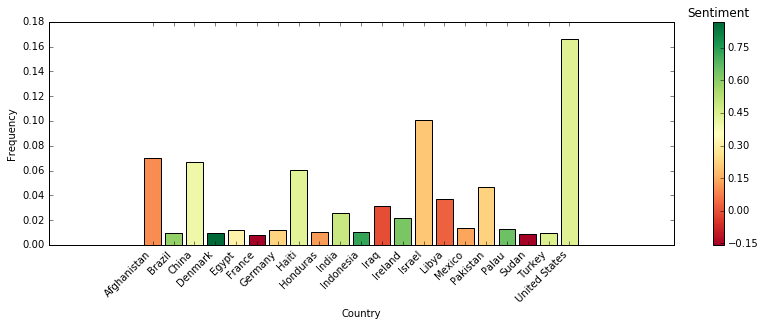

In [17]:
finaldf = sentiment_final[sentiment_final['Occurences']>0.008]

# Set up colors : red to green
plt.figure(figsize=(14, 4))
y = np.array(finaldf['Sentiment'])
colors = cm.RdYlGn(y / float(max(y)))
plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(range(finaldf.shape[0]), finaldf['Occurences'], align='center', tick_label=finaldf.index, color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.show()

We can see that the United States are the most frequently cited country, and it is cited with a positive sentiment, which seems absolutely reasonable knowing a minimum who is Hillary Clinton. Moreover, France, Iraq, Lybia and Sudan are the 4 most frequent countries with a negative sentiment about them, while the sentiment about Afghanistan is not so positive neither, but stays neutral. A positive sentiment is given to China, Haïti, India and Ireland for example, to cite only the most frequently mentioned countries. 